In [1]:
import numpy as np
import pandas as pd
import random
import time
import math
import random
import os
import sys
from datetime import datetime
import matplotlib.pyplot as plt

# Notebook path
current_directory = os.getcwd()
# Get one behind for calling the other modules
root_directory = os.path.abspath(os.path.join(current_directory, '..'))
sys.path.append(root_directory)

#Network and measures
#from to_get_data.net_construction_vis_measures import *
#Agrobiodiversity
from to_get_data.agrobiodiversity_data import *

from model_class.Variety import Variety

In [2]:
## CLase UD 
## Class with endogamy. In other words, UDs in this model belong to the same clan and the only criteria is 
# the incest rule and some probabilities related to distance. 
#This particular Class is used to set a limit in the number of UD on the model 0,1,2,3,4,5,7,8
###Relações na lista de parentes
#0. Pais do homem [0]
#1. Pais da mulher [1]
#2. Filhos [2]
#3. Avos [3] 
#4. Irmãos [4]
#5. Tios [5]
#6. Primos [6]
#7. Netos [7]
#8. Sobrinhos [8]
#9. Cassais passados [9]

### Filhos tem sexo e idade
#[sexo, idade]

class UD:
    #Dict de todas as UDs
    uds = {}

    def __init__(self, id_ud, media, community):
        self.id = id_ud
        self.parentes = [None]*10
        self.age = 1
        self.filhos = [None] * (np.random.poisson(media))
        self.uds[id_ud] = self
        self.activa = True 
        self.varieties = []
        self.community = community

    def ter_filho(self):
        # Tem espaco para ter filhos?, aleatoriamente para nao ter filhos todo ano. 
        if None in self.filhos and random.random() <= 0.3:
            # Coloca o filho no primeiro None
            for i in range(len(self.filhos)):
                if self.filhos[i] is None:
                    self.filhos[i] = [random.choice([0, 1]), 0] #[sexo, idade] e no sexo: 0 é feminino e 1 é masculino
                    break
        else:
            pass #print(f"Unidade {self.id} No tem para ter filhos!")

    def incrementar_idade(self):
        self.age += 1
        ## idade dos filhos no self.filhos
        for i in range(len(self.filhos)):
            if self.filhos[i] is not None:
                self.filhos[i][1] += 1
            else:
                break

    def death_probability(self, beta):
        alpha = 0.01
        delta = 0.00
        mortality_rate = alpha * math.exp(beta * (self.age)) + delta

        if random.random() < mortality_rate:
            self.activa = False

    def buscar_ud(self, media, matrilinear, locality): #metodo para buscar e reproducir.
        #Function to get a random couple
        def select_new_ud (selected_ud, uds_disponiveis):
            if len(uds_disponiveis) != 0: #If there are no possible mates
                #La verdad creo que es mas eficiente si no creo los ceros sino una con las comunidades y ahi opero sobre eso.
                probabilidad = np.zeros(len(uds_disponiveis))
                for i, obj in enumerate(uds_disponiveis):
                    if obj.community == selected_ud.community:
                        # Asignar una probabilidad alta si el objeto pertenece a la misma comunidad
                        probabilidad[i] = 1.0
                    else:
                        # Asignar una probabilidad uniforme si el objeto pertenece a una comunidad diferente
                        probabilidad[i] = 1.0 / len(uds_disponiveis)
                prob_normalized = probabilidad / np.sum(probabilidad)
                #print(len(prob_normalized))
                choosen_ud = np.random.choice(uds_disponiveis, p=prob_normalized)
                return choosen_ud
            else:
                return False
        
        #Função para facilitar a busqueda de ids dentro da lista de parentes.
        def is_id_in_nested_lists(id_ud, nested_list):
            if id_ud in nested_list:
                return True
            for sublist in nested_list:
                if isinstance(sublist, list) and is_id_in_nested_lists(id_ud, sublist):
                    return True
            return False
        
        #Função para facilitar a busqueda de filhos segundo o sexo
        def filho_e_idade(self, sexo):
            for i in range(len(self.filhos)):
                filho = self.filhos[i]
                #Se o sexo é o que estamos procurando e se a idade é permitida para o casamento
                if filho is not None and filho[0] == sexo and filho[1] > 13:
                    return (True, i, filho[1])  # True, a posição e a idade

            return (False, None, None)  # False, None e None
        
        filha_disponivel, posição_filha, idade_filha = filho_e_idade(self, 0) #Se a unidade tem uma filha disponivel para procurar esposa
        if filha_disponivel:
            uds_disponiveis = [ud for id_ud, ud in self.uds.items() if
                    id_ud != self.id and #Que a UD não seja self
                    not is_id_in_nested_lists(id_ud, [self.parentes[i] for i in [0, 1, 2, 3, 4, 5, 7, 8]]) and # Que a UD não seja um parent
                    filho_e_idade(ud,1)[0] and #Que tenha um filho
                    abs(filho_e_idade(ud,1)[2] - idade_filha) <= 13 #Que a diferença entre as idades não seja maior a 10
                      ]
            new_couple = select_new_ud(self, uds_disponiveis)
            
            if new_couple:
                cassal_id = new_couple.id
                filho_disponivel, posição_filho, idade_filho = filho_e_idade(UD.uds[cassal_id], 1)
                #print(filho_disponivel, posição_filho, idade_filho)
                #Agregar no espaço de casais passados [9]
                if self.parentes[9] is None: 
                    # Se a lista não existe, cria uma nova com esse id
                    self.parentes[9] = [cassal_id]
                else:
                    # Se a lista já existe, só agrega o id
                    self.parentes[9].append(cassal_id)
                if self.uds[cassal_id].parentes[9] is None: 
                    # Se a lista não existe, cria uma nova com esse id
                    self.uds[cassal_id].parentes[9] = [self.id]
                else:
                    # Se a lista já existe, só agrega o id
                    self.uds[cassal_id].parentes[9].append(self.id)   

                #### Criar um novo filho e asignar os parentes
                novo_id = max(self.uds) + 1
                if locality == True:
                    novo_nodo = UD(novo_id, media, self.uds[cassal_id].community) #Matri/Uxirocal
                else:
                    novo_nodo = UD(novo_id, media, self.community) #Patri/Virilocal
                novo_nodo.parentes[0] = self.id   # Pais do homem [0]
                novo_nodo.parentes[1] = cassal_id # Pais da mulher [1] 
                
                #####Avos[3]
                # IDs do pai
                padre_self = self.parentes[0]
                madre_self = self.parentes[1]
                # IDs da mae
                pareja = self.uds[cassal_id]
                padre_pareja = pareja.parentes[0]
                madre_pareja = pareja.parentes[1]
                # Agregar os pais dos pais do novo_nodo como avos
                novo_nodo.parentes[3] = [valor for valor in [padre_self, madre_self, padre_pareja, madre_pareja] if valor is not None]
                ###Proceso de atualização: netos
                # Se novo_nodo tem avos 
                if None not in novo_nodo.parentes[3]:
                    # IDs dos avos de novo_nodo
                    abuelos_ids = novo_nodo.parentes[3]
                # Agregar aos avos o novo_nodo como neto.
                for abuelo_id in abuelos_ids:
                    if abuelo_id is not None:
                        abuelo = self.uds[abuelo_id]
                        if abuelo.parentes[7] is None:
                            abuelo.parentes[7] = [novo_nodo.id]
                        else:
                            abuelo.parentes[7].append(novo_nodo.id)
                
                #### Irmãos [4]
                hermanos_ids = []
                if novo_nodo.parentes[0] is not None:
                    # Filhos dos pais do novo_nodo (irmãos por parte do pai)
                    padre_nuevo = self.uds[novo_nodo.parentes[0]]
                    if padre_nuevo.parentes[2] is not None:
                        hermanos_ids.extend(padre_nuevo.parentes[2])
                if novo_nodo.parentes[1] is not None:
                    # Filhos dos pais do novo_nodo (irmãos por parte da mãe)
                    madre_nuevo = self.uds[novo_nodo.parentes[1]]
                    if madre_nuevo.parentes[2] is not None:
                        hermanos_ids.extend(madre_nuevo.parentes[2])
                # Não ter o id de novo_nodo como irmão
                hermanos_ids = [hermano_id for hermano_id in hermanos_ids if hermano_id != novo_nodo.id]
                # Agregar aos irmãos de novo_nodo
                novo_nodo.parentes[4] = hermanos_ids
                
                ##Proceso de atualização: irmãos
                # ID de novo_nodo nos irmãos existentes
                for hermano_id in hermanos_ids:
                    hermano = self.uds[hermano_id]
                    if hermano.parentes[4] is None:
                        hermano.parentes[4] = [novo_nodo.id]
                    else:
                        hermano.parentes[4].append(novo_nodo.id)
                #####Tios[5]
                # IDs dos avos de novo_nodo
                abuelos_ids = novo_nodo.parentes[3]
                
                # Iterar nos avos para encontrar os tios
                tios_ids = [hermano_id for abuelo_id in abuelos_ids if abuelo_id is not None
                            for hermano_id in self.uds[abuelo_id].parentes[2] if hermano_id is not None
                            if hermano_id != novo_nodo.parentes[0] and hermano_id != novo_nodo.parentes[1]]
                # Agregar os IDs dos tios no novo_nodo
                novo_nodo.parentes[5] = tios_ids
                
                ##Proceso de atualização: sobrinhos
                # Actualizar os sobrinhos dos tios.
                for tio_id in tios_ids:
                    if tio_id is not None:
                        tio = self.uds[tio_id]
                        if tio.parentes[8] is None:
                            # Se não existe, cria lisa com o id de novo_nodo
                            tio.parentes[8] = [novo_nodo.id]
                        else:
                            # Se existe, agregar o id de novo_nodo
                            tio.parentes[8].append(novo_nodo.id)
                
                #### Primos[6]
                primos_ids = [primo_id for tio_id in tios_ids if tio_id is not None
                            for tio in [self.uds[tio_id]] if tio.parentes[2] is not None
                            for primo_id in tio.parentes[2] if primo_id is not None and primo_id != novo_nodo.id]

                # Agregar os IDs dos primos no novo_nodo
                novo_nodo.parentes[6] = primos_ids
                
                ##Proceso de atualização: sobrinhos
                for primo_id in primos_ids:
                    if primo_id is not None:
                        primo = self.uds[primo_id]
                        if primo.parentes[6] is None:
                            # Se não existe, cria lisa com o id de novo_nodo
                            primo.parentes[6] = [novo_nodo.id]
                        else:
                            # Se existe, agregar o id de novo_nodo
                            primo.parentes[6].append(novo_nodo.id)
                            
                ####Sobrinos[8] 
                sobrinos_ids = [sobrino_id for hermano_id in hermanos_ids if hermano_id is not None
                                for hermano in [self.uds[hermano_id]] if hermano.parentes[2] is not None
                                for sobrino_id in hermano.parentes[2] if sobrino_id is not None and sobrino_id != novo_nodo.id]

                # Agregar os IDs dos sobrinhos no novo_nodo
                novo_nodo.parentes[8] = sobrinos_ids
                
                ##Proceso de atualização: tios
                for sobrino_id in sobrinos_ids:
                    if sobrino_id is not None:
                        sobrino = self.uds[sobrino_id]
                        if sobrino.parentes[5] is None:
                            # Se não existe, cria lisa com o id de novo_nodo
                            sobrino.parentes[5] = [novo_nodo.id]
                        else:
                            # Se existe, agregar o id de novo_nodo
                            sobrino.parentes[5].append(novo_nodo.id)
                            
                            
                ### Eliminar os filhos utilizados no processo
                self.filhos.pop(posição_filha)
                self.uds[cassal_id].filhos.pop(posição_filho)
                
                # colcoar o novo filho dos pais
                if self.parentes[2] is None:
                    self.parentes[2] = [novo_id]
                else:
                    self.parentes[2].append(novo_id)
                if self.uds[cassal_id].parentes[2] is None:
                    self.uds[cassal_id].parentes[2] = [novo_id]
                else:
                    self.uds[cassal_id].parentes[2].append(novo_id)
                
                # Herdar sementes
                novo_nodo.heredar(matrilinear)
                
                #return None
            else:
                #print(f"UD {self.id} não achou cassal.")
                return None

        else:
            #print(f"UD {self.id} não achou ninguem")
            return None

    def heredar(self, matrilinear): #Metodo da herança de sementes.
        vm = UD.uds[self.parentes[1]].varieties
        vp = UD.uds[self.parentes[0]].varieties
        heredar_mae = math.ceil((matrilinear * len(vm))/100)
        heredar_pai = math.ceil(((100-matrilinear) * len(vp))/100)
        vari_mae = vm[0:heredar_mae] #as primeiras variedades
        vari_pai = vp[0:heredar_pai] #as primeiras variedades
        # Mutacao
#        if random.random() < 0.001:
#            # uma aleatoria
#            variedad_a_mutar = random.choice(vari_mae + vari_pai)
#            # mutacao
#            variedad_a_mutar.mutation()

        # Heredar as variedades
        self.varieties.extend(vari_mae + vari_pai)

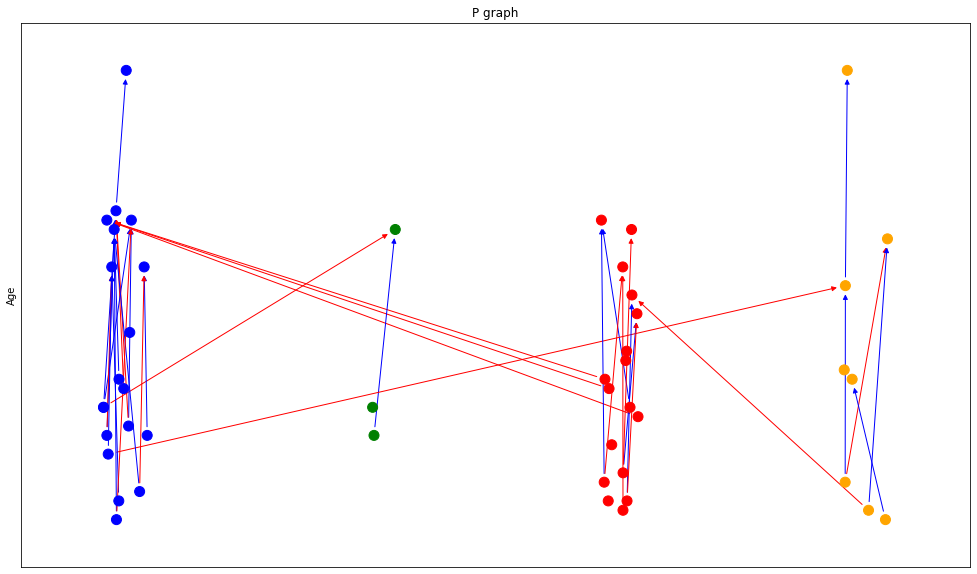

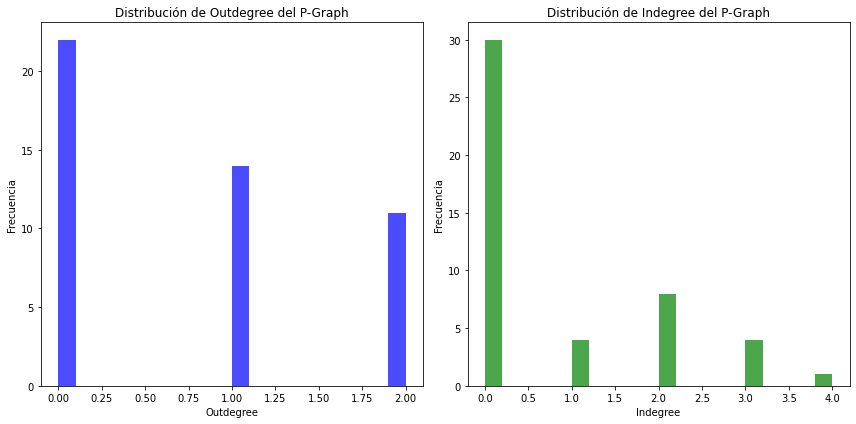

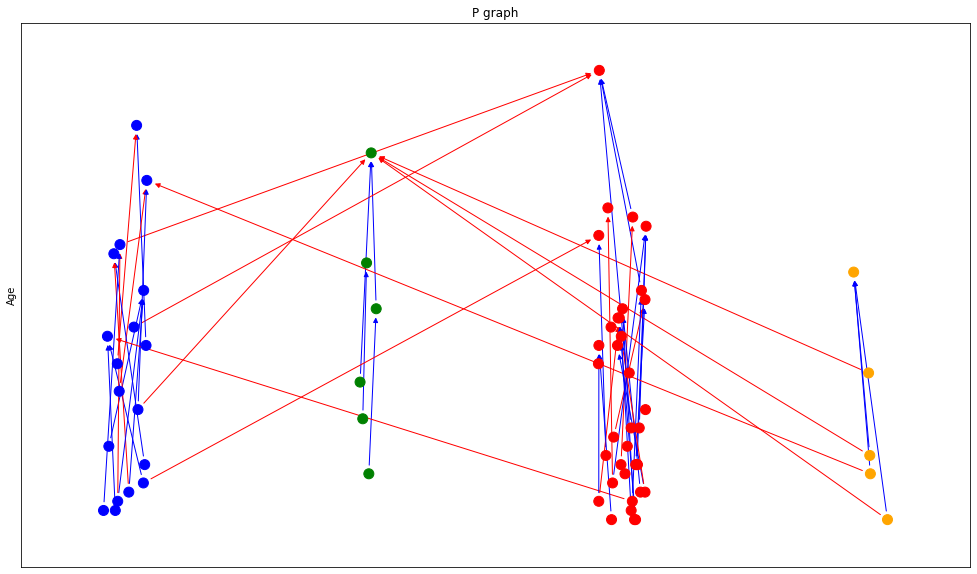

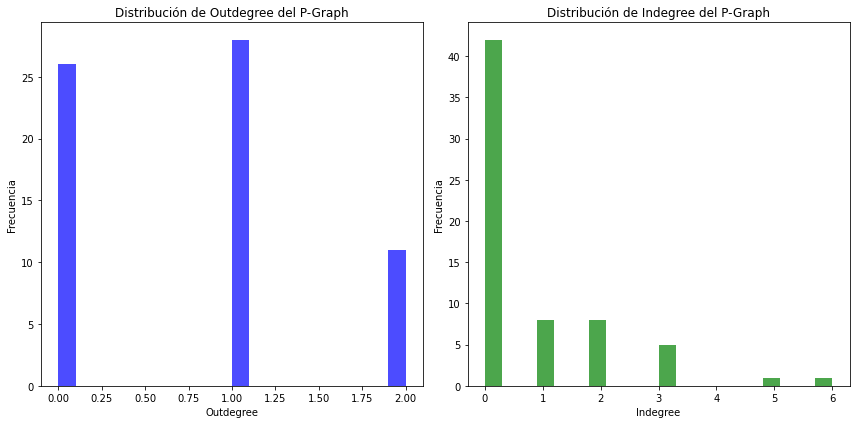

tamos en tiempo 100 con vivas 65


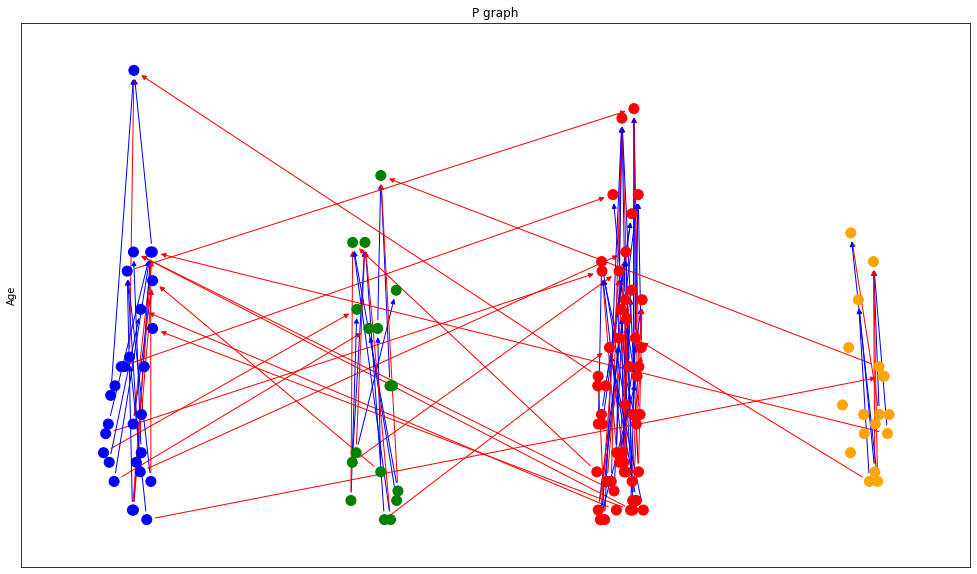

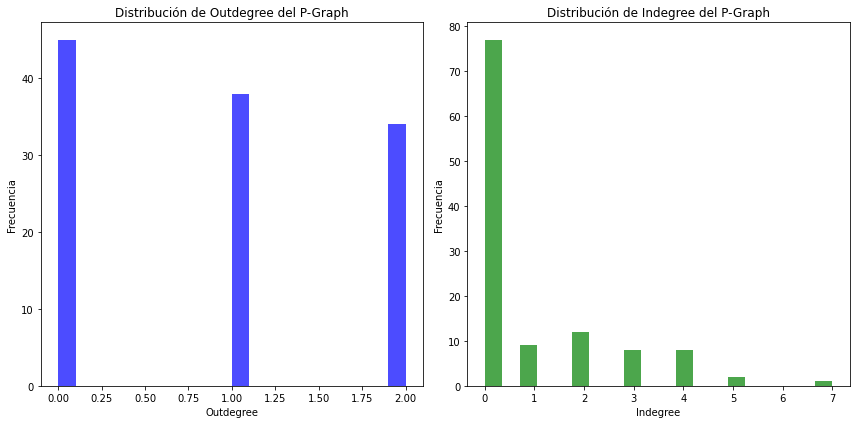

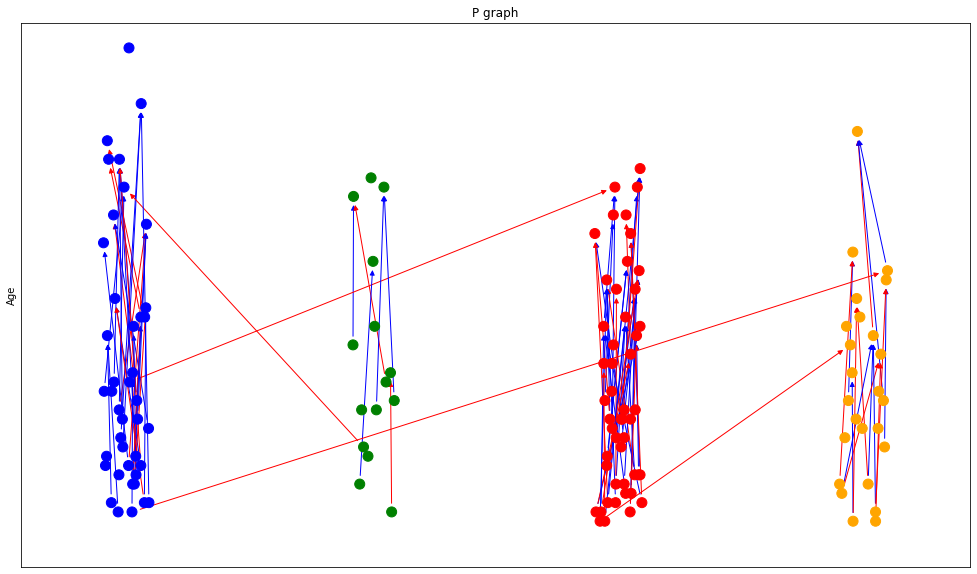

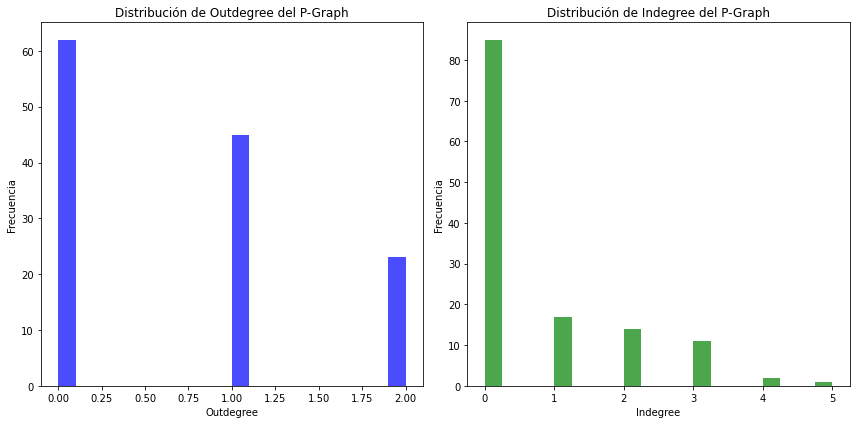

tamos en tiempo 200 con vivas 127


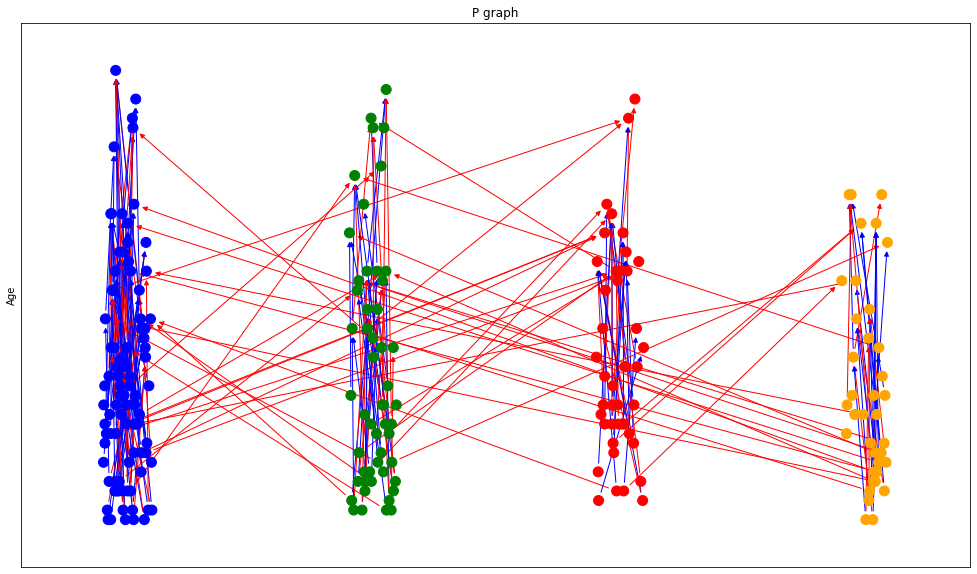

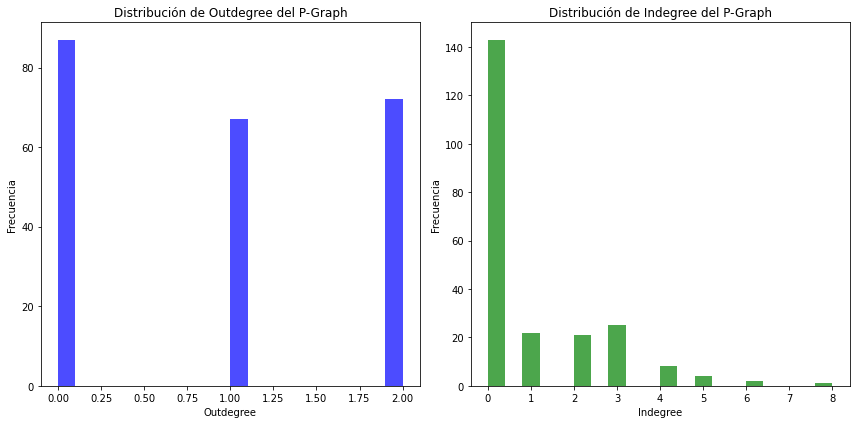

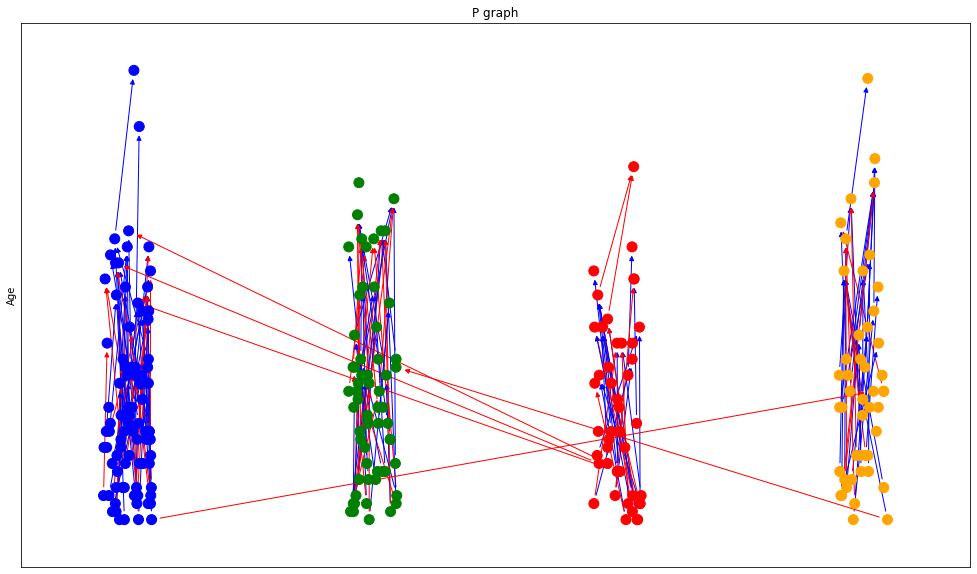

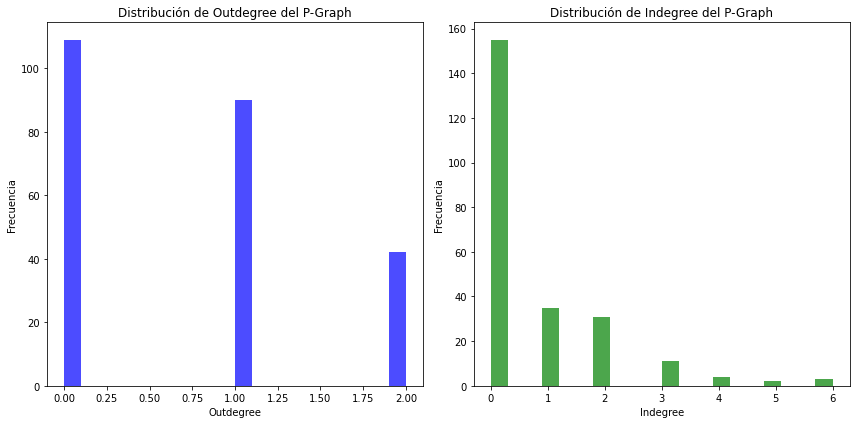

tamos en tiempo 300 con vivas 233


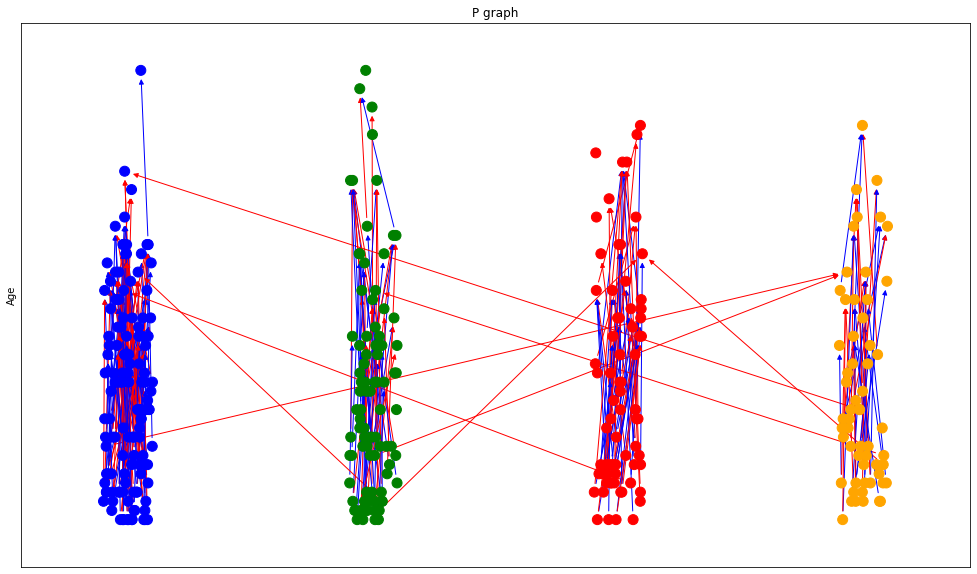

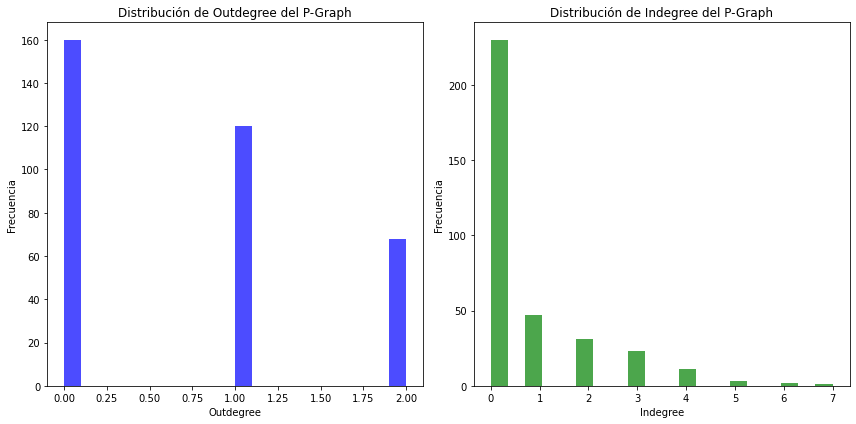

337


In [33]:
### Para cambiar
iniciais = 40 # Initial UD
prob_morte = 0.06 # Beta from the gutertz equation
media = 4 # Average children per UD
#random.seed(42) # Random seed
t = 351 #steps of the simulation
### To save the data
dataset = []
data_conections = pd.DataFrame(columns=['step','source', 'target'])
#### Initialization
## Comunidades
UD.uds = {}
comunidades_disponibles = [i for i in range(1, (int(iniciais) // 10) + 1) for _ in range(10)]
instancias_ud = []
for id_ud in range(1, int(iniciais) + 1):
    instancias_ud.append(UD(id_ud, media, comunidades_disponibles.pop(0)))
## Variedades y repartirlas entre las comunidades
for id_ud, ud in UD.uds.items():
    for _ in range(5):
        ud.varieties.append(Variety())     
    #### Simulation
original_media = media
vivas = [int(iniciais)]
for i in range(1, t):
    uds_copy = {id_ud: ud for id_ud, ud in UD.uds.items() if ud.activa}
        # if not alive
    if not uds_copy:
        print("acabo")
        break
    if i % 50 == 0:
        pass
        #Gg = create_vis_geral(uds_copy, True)
        p_graph_community(uds_copy, True)
        #dataset, data_conections = general_charactersitics_data(Gg, i, uds_copy, dataset, data_conections)        

    for id_ud, ud in uds_copy.items():
        ud.ter_filho()
        ud.buscar_ud(media, 50, False)
        ud.incrementar_idade()
        ud.death_probability(prob_morte)
     # Collecting data
    viv = len([ud for id, ud in uds_copy.items() if ud.activa])
    #mort = len([ud for id, ud in uds_copy.items() if not ud.activa])
    vivas.append(viv)
    #mortas.append(mort)
    #tempo.append(t)
    if i%100 == 0:
        print(f"tamos en tiempo {i} con vivas {viv}")
print(len([ud for id, ud in uds_copy.items() if ud.activa]))
#ejemplo, ejemplo_conections = general_charactersitics_data(0,0,0, dataset, data_conections, True)

In [15]:
import networkx as nx
def p_graph(uds_copy, measures=False):
    G = nx.DiGraph()
    ud_vivas = uds_copy

    # Actives
    #ud_vivas = {id_ud: ud for id_ud, ud in uds_copy.items() if ud.activa}

    # Agregar nodos al grafo con atributos (incluyendo edad)
    for id_ud, ud in ud_vivas.items():
        G.add_node(id_ud, ID=id_ud, age=ud.age, filhos=len(ud.parentes[2]) if ud.parentes[2] is not None else 0)

    # Agregar aristas (edges) entre nodos y sus padres
    for id_ud, ud in ud_vivas.items():
        if ud.parentes[0] is not None and ud.parentes[0] in ud_vivas:
            G.add_edge(id_ud, ud.parentes[0])
        if ud.parentes[1] is not None and ud.parentes[1] in ud_vivas:
            G.add_edge(id_ud, ud.parentes[1], color='red')  # Agregar atributo de color a la arista

    # Definir posiciones aleatorias iniciales en el eje x
    node_pos = {id_ud: (random.random(), ud.age) for id_ud, ud in ud_vivas.items()}
    
#     for id_ud, ud in ud_vivas.items():
#         if ud.parentes[0] is not None and ud.parentes[0] in node_pos:
#             parent_x = (node_pos[ud.parentes[0]][0] + random.choice([-0.005, 0.005]))
#             node_pos[id_ud] = (parent_x, ud.age)

    # Dibujar el grafo
    edge_colors = [G[u][v].get('color', 'blue') for u, v in G.edges]  # Obtener colores de las aristas

    plt.figure(figsize=(17, 10))
    nx.draw_networkx_nodes(G, node_pos, node_size=100, node_color='lightblue')
    nx.draw_networkx_edges(G, node_pos, edge_color=edge_colors, arrows=True, arrowsize=10)
    plt.title("P graph")
    plt.xlabel('')
    plt.ylabel('Age')
    plt.show()

    if measures:
        # Crear histogramas para outdegree e indegree
        outdegree_values = [outdegree for _, outdegree in G.out_degree()]
        indegree_values = [indegree for _, indegree in G.in_degree()]

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.hist(outdegree_values, bins=20, color='blue', alpha=0.7)
        plt.title('Distribución de Outdegree del P-Graph')
        plt.xlabel('Outdegree')
        plt.ylabel('Frecuencia')

        plt.subplot(1, 2, 2)
        plt.hist(indegree_values, bins=20, color='green', alpha=0.7)
        plt.title('Distribución de Indegree del P-Graph')
        plt.xlabel('Indegree')
        plt.ylabel('Frecuencia')

        plt.tight_layout()
        plt.show()

    return G


In [13]:
import networkx as nx
import matplotlib.pyplot as plt
import random

def p_graph(uds_copy, measures=False):
    G = nx.DiGraph()
    ud_vivas = uds_copy

    # Agregar nodos al grafo con atributos (incluyendo edad y comunidad)
    for id_ud, ud in ud_vivas.items():
        G.add_node(id_ud, ID=id_ud, age=ud.age, filhos=len(ud.parentes[2]) if ud.parentes[2] is not None else 0, community=ud.community)

    # Agregar aristas (edges) entre nodos y sus padres
    for id_ud, ud in ud_vivas.items():
        if ud.parentes[0] is not None and ud.parentes[0] in ud_vivas:
            G.add_edge(id_ud, ud.parentes[0])
        if ud.parentes[1] is not None and ud.parentes[1] in ud_vivas:
            G.add_edge(id_ud, ud.parentes[1], color='red')

    # Definir posiciones aleatorias iniciales en el eje x
    node_pos = {id_ud: (random.random(), ud.age) for id_ud, ud in ud_vivas.items()}

    # Agrupar nodos por comunidad
    communities = set(ud.community for ud in ud_vivas.values())
    community_colors = {com: color for com, color in zip(communities, ['blue', 'green', 'red', 'orange', 'purple'])}

    # Asignar posiciones en el layout por comunidad
    pos = nx.spring_layout(G)  # Usamos un layout de spring para visualizar mejor las comunidades
    for com in communities:
        nodes_in_com = [id_ud for id_ud, ud in ud_vivas.items() if ud.community == com]
        subgraph = G.subgraph(nodes_in_com)
        sub_pos = nx.spring_layout(subgraph)
        for node, (x, y) in sub_pos.items():
            pos[node] = (x + random.uniform(-1, 1), y + random.uniform(-1, 1))

    # Dibujar el grafo
    edge_colors = [G[u][v].get('color', 'blue') for u, v in G.edges]
    node_colors = [community_colors[G.nodes[n]['community']] for n in G.nodes]

    plt.figure(figsize=(17, 10))
    nx.draw_networkx_nodes(G, pos, node_size=100, node_color=node_colors)
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, arrows=True, arrowsize=10)
    plt.title("P graph")
    plt.xlabel('')
    plt.ylabel('Age')
    plt.show()

    if measures:
        # Crear histogramas para outdegree e indegree
        outdegree_values = [outdegree for _, outdegree in G.out_degree()]
        indegree_values = [indegree for _, indegree in G.in_degree()]

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.hist(outdegree_values, bins=20, color='blue', alpha=0.7)
        plt.title('Distribución de Outdegree del P-Graph')
        plt.xlabel('Outdegree')
        plt.ylabel('Frecuencia')

        plt.subplot(1, 2, 2)
        plt.hist(indegree_values, bins=20, color='green', alpha=0.7)
        plt.title('Distribución de Indegree del P-Graph')
        plt.xlabel('Indegree')
        plt.ylabel('Frecuencia')

        plt.tight_layout()
        plt.show()

    return G


In [10]:
import networkx as nx
import matplotlib.pyplot as plt
import random

def p_graph(uds_copy, measures=False):
    G = nx.DiGraph()
    ud_vivas = uds_copy

    # Agregar nodos al grafo con atributos (incluyendo edad y comunidad)
    for id_ud, ud in ud_vivas.items():
        G.add_node(id_ud, ID=id_ud, age=ud.age, filhos=len(ud.parentes[2]) if ud.parentes[2] is not None else 0, community=ud.community)

    # Agregar aristas (edges) entre nodos y sus padres
    for id_ud, ud in ud_vivas.items():
        if ud.parentes[0] is not None and ud.parentes[0] in ud_vivas:
            G.add_edge(id_ud, ud.parentes[0])
        if ud.parentes[1] is not None and ud.parentes[1] in ud_vivas:
            G.add_edge(id_ud, ud.parentes[1], color='red')

    # Obtener todas las comunidades
    communities = set(ud.community for ud in ud_vivas.values())
    community_colors = {com: color for com, color in zip(communities, ['blue', 'green', 'red', 'orange', 'purple'])}
    
    # Crear posiciones para cada comunidad
    pos = {}
    offset = 5  # Desplazamiento para separar las comunidades
    for i, com in enumerate(communities):
        nodes_in_com = [id_ud for id_ud, ud in ud_vivas.items() if ud.community == com]
        subgraph = G.subgraph(nodes_in_com)
        sub_pos = nx.spring_layout(subgraph, seed=42)  # Usamos una semilla para consistencia
        for node, (x, y) in sub_pos.items():
            pos[node] = (x + i * offset, y)  # Desplazar en el eje x según la comunidad

    # Dibujar el grafo
    edge_colors = [G[u][v].get('color', 'blue') for u, v in G.edges]
    node_colors = [community_colors[G.nodes[n]['community']] for n in G.nodes]

    plt.figure(figsize=(17, 10))
    nx.draw_networkx_nodes(G, pos, node_size=100, node_color=node_colors)
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, arrows=True, arrowsize=10)
    plt.title("P graph")
    plt.xlabel('')
    plt.ylabel('Age')
    plt.show()

    if measures:
        # Crear histogramas para outdegree e indegree
        outdegree_values = [outdegree for _, outdegree in G.out_degree()]
        indegree_values = [indegree for _, indegree in G.in_degree()]

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.hist(outdegree_values, bins=20, color='blue', alpha=0.7)
        plt.title('Distribución de Outdegree del P-Graph')
        plt.xlabel('Outdegree')
        plt.ylabel('Frecuencia')

        plt.subplot(1, 2, 2)
        plt.hist(indegree_values, bins=20, color='green', alpha=0.7)
        plt.title('Distribución de Indegree del P-Graph')
        plt.xlabel('Indegree')
        plt.ylabel('Frecuencia')

        plt.tight_layout()
        plt.show()

    return G


In [29]:
import networkx as nx
import matplotlib.pyplot as plt
import random
#Final p_graph for community visualization
def p_graph_community(uds_copy, measures=False):
    G = nx.DiGraph()
    ud_vivas = uds_copy

    # Agregar nodos al grafo con atributos (incluyendo edad y comunidad)
    for id_ud, ud in ud_vivas.items():
        G.add_node(id_ud, ID=id_ud, age=ud.age, filhos=len(ud.parentes[2]) if ud.parentes[2] is not None else 0, community=ud.community)

    # Agregar aristas (edges) entre nodos y sus padres
    for id_ud, ud in ud_vivas.items():
        if ud.parentes[0] is not None and ud.parentes[0] in ud_vivas:
            G.add_edge(id_ud, ud.parentes[0])
        if ud.parentes[1] is not None and ud.parentes[1] in ud_vivas:
            G.add_edge(id_ud, ud.parentes[1], color='red')

    # Obtener todas las comunidades
    communities = set(ud.community for ud in ud_vivas.values())
    community_colors = {com: color for com, color in zip(communities, ['blue', 'green', 'red', 'orange', 'purple'])}
    
    # Asignar posiciones iniciales según la comunidad y la edad
    pos = {}
    offset = 5  # Desplazamiento para separar las comunidades
    for i, com in enumerate(communities):
        nodes_in_com = [id_ud for id_ud, ud in ud_vivas.items() if ud.community == com]
        for node in nodes_in_com:
            pos[node] = (random.random() + i * offset, ud_vivas[node].age)

    # Dibujar el grafo
    edge_colors = [G[u][v].get('color', 'blue') for u, v in G.edges]
    node_colors = [community_colors[G.nodes[n]['community']] for n in G.nodes]

    plt.figure(figsize=(17, 10))
    nx.draw_networkx_nodes(G, pos, node_size=100, node_color=node_colors)
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, arrows=True, arrowsize=10)
    plt.title("P graph")
    plt.xlabel('')
    plt.ylabel('Age')
    plt.show()

    if measures:
        # Crear histogramas para outdegree e indegree
        outdegree_values = [outdegree for _, outdegree in G.out_degree()]
        indegree_values = [indegree for _, indegree in G.in_degree()]

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.hist(outdegree_values, bins=20, color='blue', alpha=0.7)
        plt.title('Distribución de Outdegree del P-Graph')
        plt.xlabel('Outdegree')
        plt.ylabel('Frecuencia')

        plt.subplot(1, 2, 2)
        plt.hist(indegree_values, bins=20, color='green', alpha=0.7)
        plt.title('Distribución de Indegree del P-Graph')
        plt.xlabel('Indegree')
        plt.ylabel('Frecuencia')

        plt.tight_layout()
        plt.show()

    return G
